In [1]:
! git clone https://github.com/HoangDuonng1359/Chest-X-Ray.git

Cloning into 'Chest-X-Ray'...
remote: Enumerating objects: 5111, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5111 (delta 0), reused 0 (delta 0), pack-reused 5108 (from 3)
Receiving objects: 100% (5111/5111), 1.94 GiB | 35.17 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (5007/5007), done.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import os
from PIL import Image
from typing import Tuple
from tqdm.auto import tqdm, trange
import torchvision.transforms.functional as f


Load data

Train: 3500, Val: 750, Test: 750  
Effusion distribution in train: Effusion  
0    2334  
1    1166  
Name: count, dtype: int64  
Effusion distribution in val: Effusion  
0    500  
1    250  
Name: count, dtype: int64  
Effusion distribution in test: Effusion  
0    500  
1    250  
Name: count, dtype: int64  

In [3]:
train_df = pd.read_csv("Chest-X-Ray/data/train_effusion.csv")
valid_df = pd.read_csv("Chest-X-Ray/data/val_effusion.csv")
test_df = pd.read_csv("Chest-X-Ray/data/test_effusion.csv")

train_df.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00016449_002.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,16449
1,00029052_005.png,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,29052
2,00028655_001.png,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28655
3,00029373_001.png,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,29373
4,00000138_001.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,138


In [4]:
train_df.columns

Index(['id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax',
       'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema',
       'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding',
       'subj_id'],
      dtype='object')

Kiểm tra rò rỉ dữ liệu

In [4]:
def check_leakage(df1, df2, column):
    """
    Kiểm tra rò rỉ dữ liệu giữa hai DataFrame dựa trên một cột.
    Trả về True nếu không có giá trị trùng lặp, False nếu có rò rỉ.
    """
    overlap = set(df1[column]).intersection(set(df2[column]))
    if len(overlap) == 0:
        return True
    else:
        return False

In [6]:
print(f"Check_leakage train - test : {check_leakage(train_df,test_df,'id')}")
print(f"Check_leakage valid - test : {check_leakage(valid_df,test_df,'id')}")

Check_leakage train - test : True
Check_leakage valid - test : True


In [7]:
print(f"Check_leakage train - valid : {check_leakage(train_df,valid_df,'id')}")

Check_leakage train - valid : True


In [8]:
overlap = set(train_df['id']).intersection(set(valid_df['id']))
train_df = train_df[~train_df['id'].isin(overlap)]

In [9]:
print(f"Check_leakage train - valid : {check_leakage(train_df,valid_df,'id')}")

Check_leakage train - valid : True


In [5]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

In [6]:
class ChestXrayBinaryDataset(Dataset):
    def __init__(self, df, image_dir, label_name, transform=None):
        """
        df: DataFrame chứa thông tin ảnh và nhãn
        image_dir: Thư mục chứa ảnh
        label_name: Tên của nhãn cần phân loại (chuỗi)
        transform: Các phép biến đổi ảnh (nếu có)
        """
        self.df = df
        self.image_dir = image_dir
        self.label_name = label_name
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Đọc ảnh
        image_path = f"{self.image_dir}/{self.df.iloc[idx]['id']}"
        image = Image.open(image_path).convert("RGB")

        # Lấy nhãn dạng nhị phân (0 hoặc 1)
        label = torch.tensor(
            self.df.iloc[idx][self.label_name], dtype=torch.float32
        )

        # Biến đổi ảnh (nếu có)
        if self.transform:
            image = self.transform(image)

        return image, label


In [7]:
import random
class RandomBottomCrop(object):
    def __init__(self, crop_height_ratio=0.5):
        self.crop_height_ratio = crop_height_ratio

    def __call__(self, img):
        w, h = img.size
        crop_h = int(h * self.crop_height_ratio)
        max_start = h - crop_h
        start_y = random.randint(max_start - crop_h//3, max_start)
        return img.crop((0, start_y, w, start_y + crop_h))

In [8]:
transform_train = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),  # hoặc BottomCrop nếu bạn muốn cố định
    transforms.Resize((320, 320)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # giúp mô hình tổng quát tốt hơn
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [9]:
transform = transforms.Compose([
    RandomBottomCrop(crop_height_ratio=0.5),
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = ChestXrayBinaryDataset(train_df, 'Chest-X-Ray/data/images',labels[2], transform_train)
valid_dataset = ChestXrayBinaryDataset(valid_df, 'Chest-X-Ray/data/images',labels[2], transform)
test_dataset =  ChestXrayBinaryDataset(test_df, 'Chest-X-Ray/data/images',labels[2], transform)

In [10]:
def display_label(label_name):
    counts = train_df[label_name].value_counts()
    plt.figure(figsize=(5,4))
    sns.barplot(x=counts.index.astype(int), y=counts.values)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(f'Label distribution in train_dataset ({label_name})')
    plt.show()

In [11]:
min_diff = float('inf')
min_label = ""

for label in labels:
    count_1 = train_df[label].sum()
    count_0 = len(train_df) - count_1
    diff = abs(count_1 - count_0)
    if diff < min_diff:
        min_diff = diff
        min_label = label

print(f"Nhãn có tỷ lệ chênh lệch giữa 0 và 1 ít nhất là: {min_label} (chênh lệch {int(min_diff)} mẫu)")

Nhãn có tỷ lệ chênh lệch giữa 0 và 1 ít nhất là: Effusion (chênh lệch 1140 mẫu)


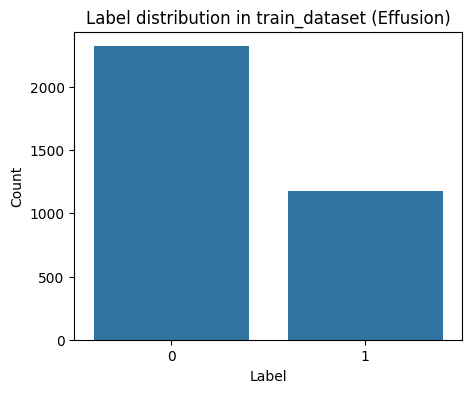

In [17]:
display_label('Effusion')

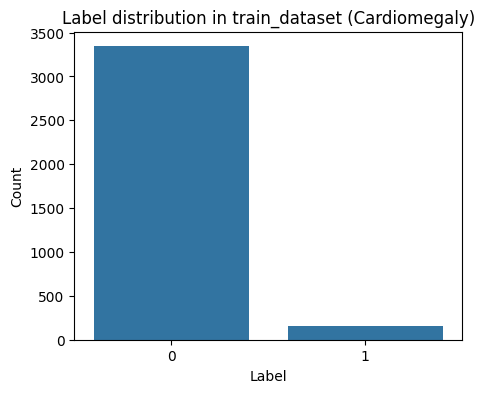

In [18]:
display_label(labels[0])

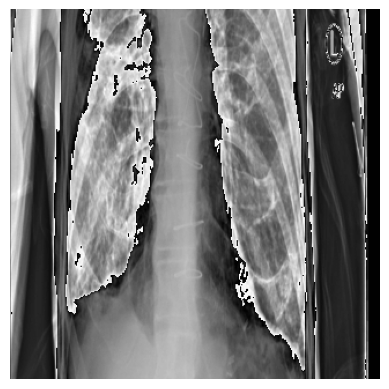

tensor(1.)


In [19]:
# Lấy ảnh và nhãn đầu tiên từ dataset
image, label = test_dataset[9]

# chuyển sang numpy và đưa về [H,W,C]
if isinstance(image, torch.Tensor):
    image = f.to_pil_image(image)
plt.imshow(image)
plt.axis("off")
plt.show()
print(label)

In [12]:
def weighted_bce_loss(outputs, targets):
    """
    Hàm tính BCE có trọng số cho bài toán mất cân bằng nhãn.

    Args:
        outputs: Tensor đầu ra của model sau sigmoid, kích thước (batch_size, num_classes)
        targets: Tensor nhãn thật (0 hoặc 1), cùng kích thước với outputs

    Returns:
        loss: Giá trị loss trung bình đã cân bằng theo nhãn
    """
    # Tính số lượng positive và negative
    pos_mask = targets == 1
    neg_mask = targets == 0

    num_pos = pos_mask.sum().item()
    num_neg = neg_mask.sum().item()
    total = num_pos + num_neg

    # Tránh chia 0
    if total == 0:
        return torch.tensor(0.0, requires_grad=True)

    # Tính trọng số theo tần suất ngược
    freq_pos = num_pos / total
    freq_neg = num_neg / total

    w_pos = freq_neg
    w_neg = freq_pos

    # Hàm BCE không giảm (tính từng phần tử)
    bce = nn.BCELoss(reduction='none')
    loss_matrix = bce(outputs, targets)

    # Áp dụng trọng số theo nhãn
    weights = torch.where(targets == 1, w_pos, w_neg)
    weighted_loss = (weights * loss_matrix).mean()

    return weighted_loss

In [13]:
class Bottleneck(nn.Module):
    expansion = 4  # output_channels = out_channels * 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1):  # Binary classification → num_classes = 1
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [14]:
def evaluate(net: nn.Module, data) -> float:
    """
    Evaluates the neural network on the given data.
    @param net: the neural network to evaluate
    @param data: the data to evaluate on
    @return: the accuracy of the neural network on the given data
    """
    data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=False)

    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)
            outputs = net(inputs)
            pred_target = (outputs > 0.5).float()
            correct += (pred_target == targets).sum().item()
            total += targets.size(0)

    return correct / total


In [15]:
def train(train_data,
          val_data,
          test_dataset,
          net,
          patience=10,  # số epoch không cải thiện trước khi dừng
          **kwargs) -> Tuple[nn.Module, list[float], list[float], list[float], list[float]]:

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=kwargs['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=kwargs['batch_size'], shuffle=False)

    optimizer = torch.optim.Adam(net.parameters(), lr=kwargs['lr'], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=kwargs['epochs'])

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    pbar = trange(kwargs['epochs'])
    for epoch in pbar:
        net.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = weighted_bce_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            running_loss += loss.item()

        scheduler.step()

        # Đánh giá train
        train_accuracy = evaluate(net, train_data)
        train_accuracies.append(train_accuracy)

        # Đánh giá validation
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device).float().unsqueeze(1)
                outputs = net(inputs)
                loss = weighted_bce_loss(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_accuracy = evaluate(net, val_data)
        test_accuracy = evaluate(net, test_dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early Stopping
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_model_state = net.state_dict()
        #     epochs_no_improve = 0
        # else:
        #     epochs_no_improve += 1
        #     if epochs_no_improve >= patience:
        #         print(f"Early stopping at epoch {epoch+1}")
        #         break

        pbar.set_description(
            f"Epoch {epoch+1} | TrainLoss: {running_loss/len(train_loader):.4f} | "
            f"TrainAcc: {train_accuracy:.4f} | ValLoss: {val_loss:.4f} | ValAcc: {val_accuracy:.4f} | TestAcc: {test_accuracy:.4f}"
        )

    # Load best model weights
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    return net, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
net = ResNet50()
lr = 5e-4
batch_size = 32
epochs = 100
net, train_losses, train_accuracies, val_losses, val_accuracies = train(train_data=train_dataset,
                                            val_data=valid_dataset,
                                            test_dataset=test_dataset,
                                            net=net,
                                            lr=lr,
                                            optimizer='adam',
                                            batch_size=batch_size,
                                            epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(train_accuracies)

In [ ]:
plt.plot(val_losses)

In [ ]:
print(evaluate(net, test_dataset))

In [ ]:
torch.save(net, './model/model_Effusion.pth')

In [ ]:
print(labels[4])

In [ ]:
display_label(labels[0])

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_probs_and_labels(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()
    probs = []
    labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            probs.extend(out.cpu().numpy().flatten())
            labels.extend(y.cpu().numpy().flatten())
    return np.array(probs), np.array(labels)

# Lấy xác suất và nhãn thực tế cho cả 2 model
probs1, labels1 = get_probs_and_labels(net, test_dataset)
#probs2, labels2 = get_probs_and_labels(net_Infiltration, test_dataset_Infiltration)

# Tính ROC và AUC
fpr1, tpr1, _ = roc_curve(labels1, probs1)
#fpr2, tpr2, _ = roc_curve(labels2, probs2)
auc1 = auc(fpr1, tpr1)
#auc2 = auc(fpr2, tpr2)

# Vẽ
plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, label=f'Model 1 (AUC = {auc1:.2f})')
#plt.plot(fpr2, tpr2, label=f'Model 2 (AUC = {auc2:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def get_probs_and_labels(model, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval()
    probs = []
    labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            probs.extend(out.cpu().numpy().flatten())
            labels.extend(y.cpu().numpy().flatten())
    return np.array(probs), np.array(labels)

# Lấy xác suất và nhãn thực tế cho cả 2 model
probs1, labels1 = get_probs_and_labels(net, test_dataset)
#probs2, labels2 = get_probs_and_labels(net_Infiltration, test_dataset_Infiltration)

# Tính ROC và AUC
fpr1, tpr1, _ = roc_curve(labels1, probs1)
#fpr2, tpr2, _ = roc_curve(labels2, probs2)
auc1 = auc(fpr1, tpr1)
#auc2 = auc(fpr2, tpr2)

# Vẽ
plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, label=f'Model Effusion (AUC = {auc1:.3f})')
#plt.plot(fpr2, tpr2, label=f'Model 2 (AUC = {auc2:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [ ]:
# ...existing code...
plt.figure(figsize=(7,7))
plt.plot(fpr1, tpr1, color='blue', linewidth=2, label=f'Model Effusion (AUC = {auc1:.3f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(fontsize=13, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
# ...existing code...

In [ ]:
print("Unique predicted probs:", np.unique(probs1))
print("Unique true labels:", np.unique(labels1))

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# 1. Load model pretrained hoặc custom
# ...existing code...
model = ResNet50()  # bạn cần định nghĩa class ResNet50 hoặc import nó
model = torch.load('Chest-X-Ray/model/model_Effusion.pth', map_location='cpu', weights_only=False)
model.eval()


# ...existing code...

# 2. Load ảnh
image_path = 'Chest-X-Ray/data/images/00019299_009.png'  # Đường dẫn ảnh X-quang
image = Image.open(image_path).convert('RGB')

# 3. Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # chuẩn cho ImageNet
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # Thêm batch dim
with torch.no_grad():
    prob = model(input_tensor)
    print("Xác suất dự đoán (Effusion):", prob.item())
# 4. Lấy layer cuối cùng trước fc (tùy theo model bạn dùng)
target_layer = model.layer4[-1]

# 5. Sử dụng Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Nếu bạn muốn focus vào 1 class cụ thể (ví dụ: class 1)
targets = None  # hoặc [ClassifierOutputTarget(class_idx)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# 6. Visualize Grad-CAM
rgb_img = cv2.cvtColor(np.array(image.resize((320, 320))), cv2.COLOR_RGB2BGR)
# Resize ảnh Grad-CAM về cùng kích thước với ảnh RGB
grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

# Hiển thị Grad-CAM
visualization = show_cam_on_image(rgb_img / 255.0, grayscale_cam_resized)  # Chia 255 để chuẩn hóa về [0,1]

# ...existing code...

# Hiển thị song song ảnh gốc và ảnh Grad-CAM
plt.figure(figsize=(10, 5))

# Ảnh gốc
plt.subplot(1, 2, 1)
plt.imshow(image.resize((320, 320)))
plt.title("Ảnh gốc")
plt.axis('off')

# Ảnh Grad-CAM
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM\np: {prob.item():.3f}")
plt.axis('off')

plt.tight_layout()
plt.show()
# ...existing code...
